# **IMPORTS**

In [60]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import warnings 

import matplotlib.pyplot as plt
from datetime import datetime

from typing import Callable

from tqdm import tqdm

from pathlib import Path

root_to_data = Path('/kaggle/input/timeseries')

import pickle

warnings.simplefilter('ignore')

data_columns = [
    'account_id', 'name', 
    'point', 'call_count', 
    'total_call_time', 'total_exclusive_time', 
    'min_call_time', 'max_call_time', 
    'sum_of_squares', 'instances', 
    'language', 'app_name', 
    'app_id', 'scope', 'host', 
    'display_host', 'pid', 
    'agent_version', 'labels'
]

delete_columns = ['agent_version', 'labels', 'account_id', 'name', 'language', 'app_name', 'app_id', 'host', 'display_host']

# **DATA**

In [62]:
def load_data():
    data_columns = [
        'account_id', 'name', 'point', 'call_count', 'total_call_time', 'total_exclusive_time', 'min_call_time', 'max_call_time', 'sum_of_squares', 'instances', 'language', 'app_name', 'app_id', 'scope', 'host', 'display_host', 'pid', 'agent_version', 'labels'
    ]

    df = pd.read_csv(f'{root_to_data}/slice_data (1).csv', sep='\t', names=data_columns)
    df = df.fillna('')

    return df


def base_proect(df: pd.DataFrame, proect_fun: Callable):
    list_of_data = df.to_dict('records')

    res_list = []
    for data in list_of_data:
        time = data['point']
        time = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')

        timestamp = int(time.timestamp())
        value = proect_fun(data)
        if value is None:
            continue

        res_list.append(
            {timestamp: value}
        )

    return res_list


def web_response(data: dict):
    check = data['language'] == 'java' and data['app_name'] == '[GMonit] Collector' and data['scope'] == '' and data['name'] == 'HttpDispatcher'
    if not check:
        return None

    total_call_time = data['total_call_time']
    call_count = data['call_count']
    if total_call_time and call_count:
        return total_call_time / call_count
    else:
        return 0


def throughput(data: dict):
    check = data['language'] == 'java' and data['app_name'] == '[GMonit] Collector' and data['scope'] == '' and data['name'] == 'HttpDispatcher'
    if not check:
        return None

    call_count = data['call_count']
    if call_count:
        return call_count
    else:
        return 0


def apdex(data: dict):
    check = data['language'] == 'java' and data['app_name'] == '[GMonit] Collector' and data['scope'] == '' and data['name'] == 'Apdex'
    if not check:
        return None

    s = data['call_count']
    t = data['total_call_time']
    f = data['total_exclusive_time']

    if s and t and f:
        return (s + t/2) / (s + t + f)
    else:
        return 0


In [63]:
df = load_data()
web_response_list = base_proect(df, web_response)
throughput_list = base_proect(df, throughput)
apdex_list = base_proect(df, apdex)

print(df.shape, '\n', df.head(3))

(300, 19) 
    account_id            name                point  call_count  \
0           1  HttpDispatcher  2024-05-13 00:58:00      1317.5   
1           1  HttpDispatcher  2024-05-13 00:59:00      2624.5   
2           1  HttpDispatcher  2024-05-13 01:00:00      2654.5   

   total_call_time  total_exclusive_time  min_call_time  max_call_time  \
0        10.690983             10.690983       0.000123       1.071242   
1        20.925472             20.925472       0.000123       1.584442   
2        20.345570             20.345570       0.000116       1.584442   

   sum_of_squares  instances language            app_name          app_id  \
0        1.777954        0.5     java  [GMonit] Collector  17592186045423   
1        4.312097        1.0     java  [GMonit] Collector  17592186045423   
2        4.929003        1.0     java  [GMonit] Collector  17592186045423   

  scope          host  display_host  pid agent_version labels  
0        575f5ba20b4b  575f5ba20b4b    1         8.5.

In [64]:
def make_plot_timestamp_value(timestamps : list, values : list):
    plt.figure(figsize=(10, 5))
    plt.plot(timestamps, values, marker='o', linestyle='-', color='b')
    plt.title('Все временные метки')
    plt.xlabel('Дата')
    plt.ylabel('Значение')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



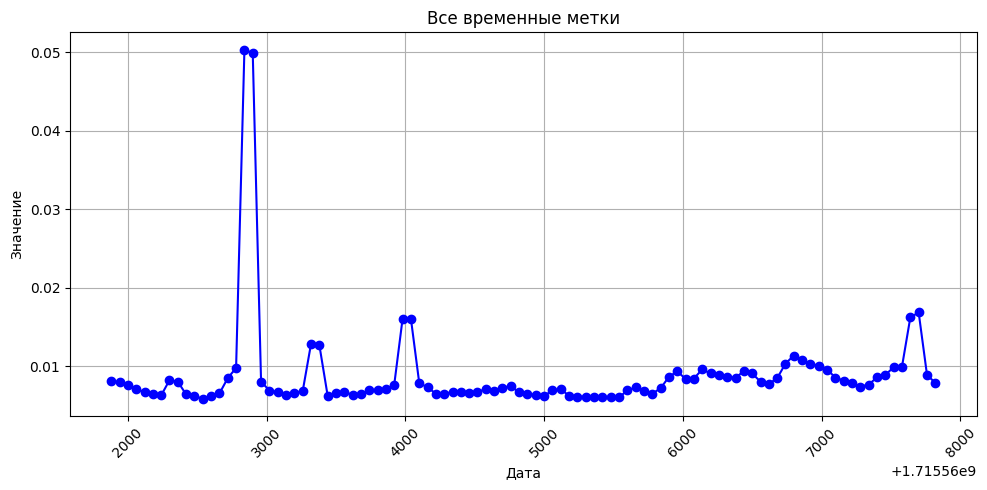


timestamps: 100 
 values: 100
CPU times: user 566 ms, sys: 274 ms, total: 840 ms
Wall time: 366 ms


In [74]:
%%time 
# исходные данные
timestamps = [list(entry.keys())[0] for entry in web_response_list] 
values = [list(entry.values())[0] for entry in web_response_list] 

make_plot_timestamp_value(timestamps, values)
print()
print(f'timestamps: {len(timestamps)} \n values: {len(values)}')

# **MODEL**

In [66]:
class TimeSeriesDataset(Dataset):
    '''
    class: Датасет с временными метками и значениями в них
    '''
    def __init__(self, timestamps, values):
        self.timestamps = timestamps
        self.values = values

    def __len__(self):
        return len(self.values)

    def __getitem__(self, id_):
        return self.timestamps[id_], self.values[id_]

In [75]:
class TimeSeriesAnomalyDetector:
    '''
    class: Детекция аномалий во временных рядах
    '''
    
    # Инициализация модели, создание слоёв и инициализайия массивов временных меток и значений
    def __init__(self, model_name: str):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.to(self.device)

        # Дополнительные слои для обнаружения аномалий
        self.fc1 = nn.Linear(self.model.config.hidden_size, 128).to(self.device)
        self.fc2 = nn.Linear(128, 1).to(self.device)  
        self.mse_loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(
            list(self.model.parameters()) + list(self.fc1.parameters()) + list(self.fc2.parameters()), 
            lr=1e-5
        )
    
    # Обработка данных
    def preprocess(self, timestamps, values):
        # Соединяем временные метки и значения в одну строку
        time_series = [f"{ts}:{val}" for ts, val in zip(timestamps, values)]
        inputs = self.tokenizer(time_series, return_tensors='pt', padding=True, truncation=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        return inputs, torch.tensor(values, dtype=torch.float32).to(self.device).unsqueeze(-1)
    
    # Прямое распространение
    def forward(self, inputs):
        outputs = self.model(**inputs)
        hidden_states = outputs.last_hidden_state
        x = torch.relu(self.fc1(hidden_states[:, 0, :]))
        reconstructions = self.fc2(x)
        return reconstructions
    
    # тренировка модели
    def train(self, train_loader, epochs=5):
        self.model.train()
        for epoch in tqdm(range(epochs)):
            total_loss = 0
            for batch in train_loader:
                timestamps, values = batch

                timestamps = [timestamp for timestamp in timestamps]
                values = [value.item() if isinstance(value, torch.Tensor) else value for value in values]

                inputs, targets = self.preprocess(timestamps, values)

                self.optimizer.zero_grad()
                reconstructions = self.forward(inputs)
                loss = self.mse_loss(reconstructions, targets)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
            print(f"Epoch {epoch + 1}/{epochs}, MSE Loss: {total_loss / len(train_loader)}")

    # Метод предсказания аномалии моделью
    def predict(self, timestamps, values):
        self.model.eval()
        with torch.no_grad():
            inputs, _ = self.preprocess(timestamps, values)
            rec = self.forward(inputs)
            rec_error = torch.mean((rec - torch.tensor(values, dtype=torch.float32).to(self.device).unsqueeze(-1)) ** 2, dim=1).cpu().numpy()

            threshold = 0.5 
            probabilities = rec_error / max(rec_error) 
            anomalies = probabilities > threshold

            return rec_error, probabilities, anomalies
    
    # Метод который выдаёт временные метки аномалий
    def detect_anomaly_intervals(self, anomalies, timestamps):
        anomaly_timestamps = []
        start = None

        for i, is_anomaly in enumerate(anomalies):
            if is_anomaly and start is None:
                start = i
            elif not is_anomaly and start is not None:
                anomaly_timestamps.extend(timestamps[start:i])
                start = None

        if start is not None:
            anomaly_timestamps.extend(timestamps[start:len(anomalies)])

        return anomaly_timestamps
    
    # Метод для оценки модели по метрике SNR
    def calculate_snr(self, values, reconstruction_error):
        signal_power = np.mean(np.square(values))
        noise_power = np.mean(np.square(reconstruction_error))
        snr = 10 * np.log10(signal_power / noise_power)
        return snr
    
    # Метод для оценки модели по метрике AnomalyScore
    def calculate_anomaly_score(self, reconstruction_error):
        mean_error = np.mean(reconstruction_error)
        std_error = np.std(reconstruction_error)
        anomaly_scores = (reconstruction_error - mean_error) / std_error
        return anomaly_scores
    
    def evaluate_model(self, timestamps, values):
        reconstruction_error, probabilities, anomalies = self.predict(timestamps, values)
        snr = self.calculate_snr(values, reconstruction_error)
        anomaly_scores = self.calculate_anomaly_score(reconstruction_error)

        print(f"SNR: {snr}")
        print(f"Anomaly Scores: {anomaly_scores}")

        return snr, anomaly_scores
    
    # Метод , который реализует сохранение модели в .pkl
    def save_model(self, file_path):
        model_state = {
            'model': self.model.state_dict(),
            'fc1': self.fc1.state_dict(),
            'fc2': self.fc2.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'tokenizer': self.tokenizer,
        }
        with open(file_path, 'wb') as f:
            pickle.dump(model_state, f)
    
    # Метод реализующий загрузку сохранённой модели со всеми её весами  
    def load_model(self, file_path):
        with open(file_path, 'rb') as f:
            model_state = pickle.load(f)
        self.model.load_state_dict(model_state['model'])
        self.fc1.load_state_dict(model_state['fc1'])
        self.fc2.load_state_dict(model_state['fc2'])
        self.optimizer.load_state_dict(model_state['optimizer'])
        self.tokenizer = model_state['tokenizer']

In [76]:
print(timestamps[:50])
print()
print(timestamps[-50:])

[1715561880, 1715561940, 1715562000, 1715562060, 1715562120, 1715562180, 1715562240, 1715562300, 1715562360, 1715562420, 1715562480, 1715562540, 1715562600, 1715562660, 1715562720, 1715562780, 1715562840, 1715562900, 1715562960, 1715563020, 1715563080, 1715563140, 1715563200, 1715563260, 1715563320, 1715563380, 1715563440, 1715563500, 1715563560, 1715563620, 1715563680, 1715563740, 1715563800, 1715563860, 1715563920, 1715563980, 1715564040, 1715564100, 1715564160, 1715564220, 1715564280, 1715564340, 1715564400, 1715564460, 1715564520, 1715564580, 1715564640, 1715564700, 1715564760, 1715564820]

[1715564880, 1715564940, 1715565000, 1715565060, 1715565120, 1715565180, 1715565240, 1715565300, 1715565360, 1715565420, 1715565480, 1715565540, 1715565600, 1715565660, 1715565720, 1715565780, 1715565840, 1715565900, 1715565960, 1715566020, 1715566080, 1715566140, 1715566200, 1715566260, 1715566320, 1715566380, 1715566440, 1715566500, 1715566560, 1715566620, 1715566680, 1715566740, 1715566800, 1

In [86]:
%time
dataset = TimeSeriesDataset(timestamps[50:], values[50:])
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

model_name = 'bert-base-uncased'
anomaly_detector = TimeSeriesAnomalyDetector(model_name)

# Train the model
anomaly_detector.train(train_loader)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


 20%|██        | 1/5 [00:01<00:06,  1.63s/it]

Epoch 1/5, MSE Loss: 0.007664473842523876


 40%|████      | 2/5 [00:03<00:04,  1.64s/it]

Epoch 2/5, MSE Loss: 0.0013615707173448754


 60%|██████    | 3/5 [00:04<00:03,  1.63s/it]

Epoch 3/5, MSE Loss: 0.0007491481622128049


 80%|████████  | 4/5 [00:06<00:01,  1.62s/it]

Epoch 4/5, MSE Loss: 0.0006790611491305754


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]

Epoch 5/5, MSE Loss: 0.0003447227497235872


In [87]:
# сохраним модель .pkl
anomaly_detector.save_model('anomaly_detector_transformers_model_mvp.pickle')

In [88]:
#теперь попробуем загрузить сохранённую модель
loaded_anomaly_detector = TimeSeriesAnomalyDetector(model_name)
loaded_anomaly_detector.load_model('anomaly_detector_transformers_model_mvp.pickle')

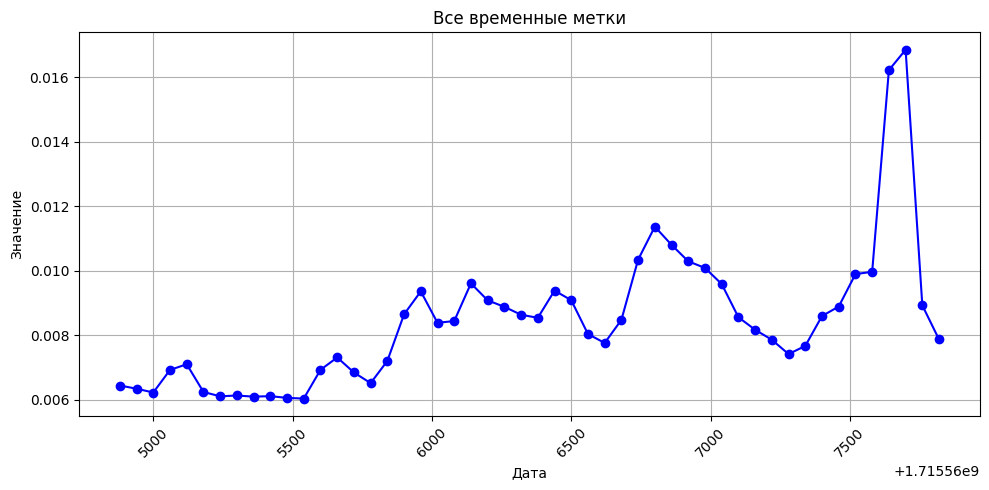

Probabilities: [0.57644695 0.4319197  0.3797233  0.09615589 0.42312968 0.03246532
 0.5825646  0.04528628 0.1505111  0.37988335 0.48141485 0.47092232
 0.4386906  0.1785232  0.12961291 0.30164596 0.20555787 0.38265252
 0.2685852  0.34498692 0.33117965 0.16598624 0.39569288 0.35717463
 0.08987827 0.28115064 0.4356504  0.32167113 0.15693107 0.07381223
 0.44307688 0.2512531  0.32110494 0.33721763 0.17909884 0.30734915
 0.82534206 1.         0.08715478 0.02621179 0.02781731 0.13051441
 0.5481799  0.4087258  0.3293966  0.17216508 0.71104485 0.7438256
 0.34671953 0.21215367]
Anomalies: [ True False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True False False False False  True False False False  True  True
 False False]
Anomaly Intervals: [1715564880, 1715565240, 1715567040, 1715567100, 1715567400, 1715567640, 1715567700]


In [89]:
# Пусть наша модель предскажет, где находятся аномалии
timestamps_test = timestamps[-50:]
values_test = values[-50:]
reconstraction_error, probabilities, anomalies = loaded_anomaly_detector.predict(timestamps_test, values_test)

make_plot_timestamp_value(timestamps_test, values_test)

print("Probabilities:", probabilities)
print("Anomalies:", anomalies)

anomaly_intervals = loaded_anomaly_detector.detect_anomaly_intervals(anomalies, timestamps_test)
print("Anomaly Intervals:", anomaly_intervals)

<h2>Оценка значения <b>SNR</b></h2>

<h4>Значение <b>SNR</b> в <i>33.106811... dB</i> указывает на очень хорошую реконструкцию данных, так как мощность сигнала значительно превышает мощность шума. В реальных приложениях такие высокие значения <b>SNR</b> являются признаком того, что модель работает очень хорошо.</h4>

<h4>Значения <b>SNR</b> интерпретируются следующим образом:</h4>

<ul>
    <li>0-10 dB: Очень плохая реконструкция, шум сопоставим с сигналом.</li>
    <li>10-20 dB: Удовлетворительная реконструкция, шум заметен, но сигнал доминирует.</li>
    <li>20-30 dB: Хорошая реконструкция, шум минимален.</li>
    <li>30+ dB: Отличная реконструкция, шум практически отсутствует.</li>
</ul>
<h4>Таким образом, значение <b>SNR</b> в <i>33.106811... dB</i> указывает на то, что модель хорошо реконструирует временной ряд и имеет минимальные ошибки реконструкции.</h4>

<h2>Оценка значения <b>Anomaly Score</b></h2>
<h3><b>Anomaly Score (оценка аномалии)</b> — это <i>численное значение</i>, которое указывает на степень отклонения текущего наблюдения от ожидаемого поведения в наборе данных. Более высокие значения часто указывают на то, что наблюдение является аномальным или необычным, тогда как более низкие значения указывают на то, что наблюдение является нормальным.</h3>

<h3>Интерпретация <i>Anomaly Score</i>:</h3>
<ol>
    <li>Положительные и отрицательные значения:</li>
    <ul>
        <li>Положительные значения аномальных оценок могут указывать на аномалии, которые превышают нормальные пределы данных.</li>
        <li>Отрицательные значения могут указывать на аномалии, которые значительно ниже нормальных пределов данных.</li>
    </ul>
    <li>Абсолютные значения:</li>
    <ul>
        <li>Большие абсолютные значения (как положительные, так и отрицательные) обычно указывают на более значительные отклонения от нормальных значений, что является признаком аномалий.</li>
    </ul>
    <li>Пороговое значение:</li>
    <ul>
        <li>Для практического применения часто устанавливается пороговое значение. Например, если абсолютное значение оценки аномалии превышает определенный порог (например, 2 или 3), то наблюдение считается аномальным.</li>
    </ul>
</ol>

In [90]:
snr, anomaly_scores = anomaly_detector.evaluate_model(timestamps_test, values_test)

SNR: 31.11039092034325
Anomaly Scores: [ 1.1998019   0.5064181   0.2560007  -1.1044421   0.46424714 -1.4100039
  1.2291521  -1.3484942  -0.8436676   0.2567686   0.74387604  0.6935372
  0.5389022  -0.7092768  -0.94392866 -0.118583   -0.57957524  0.27005398
 -0.2771954   0.08934953  0.02310779 -0.7694241   0.33261636  0.14782126
 -1.1345596  -0.21691139  0.52431655 -0.02251039 -0.81286716 -1.2116381
  0.55994576 -0.36034793 -0.02522672  0.05207559 -0.7065151  -0.09122141
  2.393901    3.23184    -1.1476259  -1.440006   -1.4323033  -0.9396037
  1.064188    0.3951431   0.01455338 -0.7397805   1.8455489   2.0028176
  0.0976619  -0.54793125]
